In [ ]:
!pip install fasttext
import fasttext
from huggingface_hub import hf_hub_download
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
model_path = hf_hub_download(repo_id="facebook/fasttext-ar-vectors", filename="model.bin")
model = fasttext.load_model(model_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
len(model.words)

2000000

In [ ]:
def extract_data(url, table_columns, cairo_districts):
  df = pd.DataFrame(columns= table_columns)
  page = requests.get(url).text
  data = BeautifulSoup(page, 'html.parser')
  uls = data.find_all('ul', class_= 'link')
  h3 = data.find_all('h3')

  for i,ul in enumerate(uls):
    list_of_districts = ul.find_all('li')
    label = None
    if(h3[i].a.contents[0] == 'القاهرة'):
      label = 1
    else:
      label = 0
    for i, district in enumerate(list_of_districts):
      if i == len(list_of_districts) - 1:
        break
      data_dict = {
          "district_name": district.a.contents[0],
          'label': label
      }
      df_temp = pd.DataFrame(data_dict, index= [0])
      df = pd.concat([df, df_temp], ignore_index = True)

  with open ('Cairo.txt', 'r') as f:
    list_ = []
    for line in f.readlines():
      list_.append(line[:-1])

  subset = [district for district, label in zip(df['district_name'], df['label']) if label == 1]
  difference_list = list(set(list_) - set(subset))

  for district in difference_list:
    data_dict = {
          "district_name": district,
          'label': 1
      }
    df_temp = pd.DataFrame(data_dict, index= [0])
    df = pd.concat([df, df_temp], ignore_index = True)

  return df



In [ ]:
url = "https://eg.dowwr.com/regions/"
table_columns = ['district_name', 'label']

In [ ]:
df = extract_data(url, table_columns, 'Cairo.txt')

In [ ]:
df.head()

,district_name,label
0,ابو الريش,0
1,ابو سمبل,0
2,ادفو,0
3,البصيلية,0
4,الرديسية,0


In [ ]:
len(df)

413

In [ ]:
df.to_csv('district_data.csv', encoding='utf-8', index=False)

In [ ]:
district_tokens = []
embeddings = []

for district in df['district_name']:
  tokens = word_tokenize(district)
  embeddings.append(np.mean([model.get_word_vector(token) for token in tokens], axis= 0))
  district_tokens.append(tokens)


In [ ]:
df_embeddings = pd.DataFrame(embeddings)

In [ ]:
df_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.020113,0.038619,-0.025801,0.028731,0.232983,-0.003282,0.075591,0.097136,-0.006230,-0.070113,...,-0.043708,-0.016309,-0.058354,0.012242,-0.011040,-0.019971,0.176365,0.025988,-0.077671,0.035623
1,-0.036470,-0.014833,0.039275,0.067893,0.284031,-0.046144,0.121496,0.122714,-0.040895,-0.155957,...,-0.095819,-0.073423,0.003372,0.003084,0.056712,0.052449,0.106780,0.033557,-0.021952,0.049117
2,0.077119,-0.024226,0.077301,0.049764,0.320695,-0.023371,0.101289,-0.057145,-0.076402,0.040142,...,-0.090503,-0.070357,0.051376,-0.010567,0.048291,0.026196,-0.025980,0.087627,0.002383,0.072401
3,0.077384,-0.013852,0.051879,0.085105,0.073722,0.009531,-0.022815,0.020477,0.011879,-0.034024,...,-0.002647,-0.023587,-0.011348,-0.004207,-0.028661,0.027502,0.049723,-0.024311,-0.041588,-0.019317
4,0.046520,-0.034087,-0.034701,0.041161,0.076133,0.010586,-0.001144,0.054442,-0.023870,-0.060203,...,-0.002910,-0.028294,-0.022261,0.037960,-0.029681,-0.004084,0.057400,0.029789,-0.021884,0.027497


In [ ]:
df_embeddings.shape

(413, 300)

In [ ]:
df_embeddings['label'] = df['label']

In [ ]:
df_embeddings.shape

(413, 301)

In [ ]:
df_embeddings.isnull().sum()

0        0
1        0
2        0
3        0
4        0
        ..
296      0
297      0
298      0
299      0
label    0
Length: 301, dtype: int64

In [ ]:
df_embeddings.to_csv('transformed_data.csv', index = False)

In [ ]:
X = np.array(df_embeddings.drop('label', axis= 1))
y = np.array(df_embeddings['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, shuffle= True)

In [ ]:
y_train.shape

(330,)

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train, y_train_encoded)
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train_encoded)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train_encoded)
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_encoded)
svm_clf = SVC(kernel='linear', C=1.0, random_state=42)
svm_clf.fit(X_train, y_train_encoded)
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_encoded, cv=3, scoring="accuracy")

array([0.81818182, 0.80909091, 0.84545455])

In [ ]:
y_train_pred = cross_val_predict(xgb_clf, X_train, y_train_encoded, cv=3)

In [ ]:
print(confusion_matrix(y_train_encoded, y_train_pred))
print(precision_score(y_train_encoded, y_train_pred))
print(recall_score(y_train_encoded, y_train_pred))
print(f1_score(y_train_encoded, y_train_pred))

[[253  16]
 [ 44  17]]
0.5151515151515151
0.2786885245901639
0.36170212765957444


In [ ]:
roc_auc_score(y_train_encoded, y_train_pred)

0.6096044853434092

-----------------------------------------------------------------------------------------------------------------------------

In [ ]:
df.head()

,district_name,label
0,ابو الريش,0
1,ابو سمبل,0
2,ادفو,0
3,البصيلية,0
4,الرديسية,0


In [ ]:
import tensorflow as tf
print(tf. __version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import GRU
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Bidirectional, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

2.15.0


In [ ]:
text_data = ' '.join(df['district_name'])
tokens = word_tokenize(text_data)
unique_words = set(tokens)
vocab_size = len(unique_words) +1
print(vocab_size)
print(unique_words)

456
{'القناطر', 'الكبرى', 'ناهيا', 'قصر', 'الجناين', 'إمبابة', 'وسط', 'الصديق', 'الاول', 'المطرية', 'الواسطي', 'المنشاة', 'مشتول', 'مدينه', 'مركز', 'صقر', 'ساقتلة', 'الخارجة', 'القنايات', 'زهراء', 'ستيفانو', 'الفشن', 'تلات', 'المنصورة', 'الحامول', 'البصيلية', 'كوم', 'الوايلي', 'زفتى', 'بهتيم', 'مطوبس', 'العين', 'فاقوس', 'الضواحي', 'مارينا', 'إسنا', 'جابر', 'الزرقا', 'قرقاص', 'إهناسيا', 'الجنوب', 'الخليفة', 'موط', 'التل', 'سمالوط', 'زيزينيا', 'بركة', 'النصر', 'كات', 'أكتوبر', 'بسيون', 'المنيا', 'سهل', 'روض', 'الدكرور', 'أجا', 'زويد', 'بولكي', 'السوق', 'قليوب', 'السبع', 'زنيمة', 'عقبة', 'سيدي', 'النوبارية', 'مايو', 'المنتزة', '6', 'الساحل', 'الطود', 'الترابين', 'مغاغة', 'طهطا', 'شيزار', 'العاصمة', 'قنا', 'فيكتوريا', 'حمص', 'جزيرة', 'قلين', 'المرج', 'بلقاس', 'الإسماعيلية', 'العمرانية', 'رمسيس', 'الرياض', 'جهينة', 'العباسية', 'نصر', 'بلبيس', 'عائشة', 'رفح', 'برج', 'رواش', 'بئر', 'الرديسية', 'شبرا', 'الرحمانية', 'فايد', 'منشأة', 'غارب', 'بني', 'براني', 'طامية', 'دراو', 'قطور', 'جليم', 'العو

In [ ]:
max_length=-1
sent = None
for sentence in df['district_name']:
  tokens = word_tokenize(sentence)
  max_length = max(max_length, len(tokens))

max_length

3

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['district_name'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df['district_name'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [ ]:
padded_sequences[0]

array([22, 61,  0], dtype=int32)

In [ ]:
for i in range(len(df['district_name'])):
    print(f"Sequence: {sequences[i]}, Words: {[word for word, index in word_index.items() if index in sequences[i]]}")

Sequence: [22, 61], Words: ['ابو', 'الريش']
Sequence: [22, 62], Words: ['ابو', 'سمبل']
Sequence: [63], Words: ['ادفو']
Sequence: [64], Words: ['البصيلية']
Sequence: [65], Words: ['الرديسية']
Sequence: [66], Words: ['السباعية']
Sequence: [67], Words: ['دراو']
Sequence: [68], Words: ['صحاري']
Sequence: [69], Words: ['كلابشة']
Sequence: [23, 70], Words: ['كوم', 'امبو']
Sequence: [1, 71], Words: ['مدينة', 'اسوان']
Sequence: [8, 72], Words: ['نصر', 'النوبة']
Sequence: [2, 73], Words: ['أبو', 'تيج']
Sequence: [74], Words: ['ابنوب']
Sequence: [24, 4], Words: ['الجديدة', 'اسيوط']
Sequence: [75], Words: ['البداري']
Sequence: [76], Words: ['الغنايم']
Sequence: [77], Words: ['الفتح']
Sequence: [78], Words: ['القوصية']
Sequence: [79], Words: ['ديروط']
Sequence: [80, 81], Words: ['ساحل', 'سليم']
Sequence: [82], Words: ['صدفا']
Sequence: [1, 24], Words: ['مدينة', 'اسيوط']
Sequence: [83], Words: ['منفوط']
Sequence: [84], Words: ['أرمنت']
Sequence: [85], Words: ['إسنا']
Sequence: [86], Words: ['البياض

In [ ]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
        embedding_vector = model.get_word_vector(word)
        embedding_matrix[i] = embedding_vector

In [ ]:
padded_sequences.shape

(413, 3)

In [ ]:
classes_count = df['label'].value_counts()
neg= classes_count[0]
pos= classes_count[1]
total= sum(classes_count)

In [ ]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

In [ ]:
class_weight

{0: 0.6091445427728613, 1: 2.790540540540541}

In [ ]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False))
lstm_model.add(LSTM(units=128))
lstm_model.add(Dense(units=1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

y = np.array(df['label'])
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42, shuffle = True)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
lstm_model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight)

loss, accuracy = lstm_model.evaluate(X_test, y_test_encoded)
print(f'Validation Accuracy: {accuracy}')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 300)            136800    
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 356577 (1.36 MB)
Trainable params: 219777 (858.50 KB)
Non-trainable params: 136800 (534.38 KB)
_________________________________________________________________
None
Epoch 1/10
9/9 [==============================] - 3s 95ms/step - loss: 0.7110 - accuracy: 0.2992 - val_loss: 0.6906 - val_accuracy: 0.4242
Epoch 2/10
9/9 [==============================] - 0s 18ms/step - loss: 0.6856 - accuracy: 0.5606 - val_loss: 0.6765 - val_accuracy: 0

In [ ]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False))
gru_model.add(GRU(units=128))
gru_model.add(Dense(units=1, activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

gru_model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight)

loss, accuracy = gru_model.evaluate(X_test, y_test_encoded)
print(f'Validation Accuracy (GRU): {accuracy}')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 300)            136800    
                                                                 
 gru (GRU)                   (None, 128)               165120    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 302049 (1.15 MB)
Trainable params: 165249 (645.50 KB)
Non-trainable params: 136800 (534.38 KB)
_________________________________________________________________
None
Epoch 1/10
9/9 [==============================] - 3s 75ms/step - loss: 0.7043 - accuracy: 0.5227 - val_loss: 0.6799 - val_accuracy: 0.4697
Epoch 2/10
9/9 [==============================] - 0s 13ms/step - loss: 0.6640 - accuracy: 0.6250 - val_loss: 0.6467 - val_accuracy:

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

birnn_model = Sequential()
birnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False))
birnn_model.add(Bidirectional(SimpleRNN(units=128)))
birnn_model.add(Dense(units=1, activation='sigmoid'))

birnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(birnn_model.summary())

birnn_model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2,class_weight=class_weight)

loss, accuracy = birnn_model.evaluate(X_test, y_test_encoded)
print(f'Validation Accuracy (Bidirectional RNN): {accuracy}')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3, 300)            136800    
                                                                 
 bidirectional (Bidirection  (None, 256)               109824    
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 246881 (964.38 KB)
Trainable params: 110081 (430.00 KB)
Non-trainable params: 136800 (534.38 KB)
_________________________________________________________________
None
Epoch 1/10
9/9 [==============================] - 2s 52ms/step - loss: 0.6717 - accuracy: 0.6705 - val_loss: 0.6091 - val_accuracy: 0.6515
Epoch 2/10
9/9 [==============================] - 0s 10ms/step 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    matching_thresholds = thresholds[(precisions[:-1] >= 0.7) & (recalls[:-1] >= 0.7)]
    # matching_thresholds = thresholds[np.isclose(precisions[:-1], recalls[:-1], atol=0.2)]

    if matching_thresholds.size > 0:
        threshold = matching_thresholds[0]
        index = np.argmax(precisions >= 0.7)
        plt.scatter([threshold], [precisions[index]], c='red', marker='o', label='threshold that get percision and recall values close')
        plt.axvline(threshold, color='gray', linestyle='--')
        plt.axhline(precisions[index], color='gray', linestyle='--')

    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision-Recall vs Threshold')
    plt.grid(True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

def plot_roc_curve_with_target_point(fpr, tpr, thresholds, target_sensitivity=0.7, target_specificity=0.8):
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))

    target_thresholds = thresholds[(tpr >= target_sensitivity) & (1 - fpr >= target_specificity)]

    if target_thresholds.size > 0:
        target_threshold = target_thresholds[0]
        index = np.argmax(tpr >= target_sensitivity)
        plt.scatter(fpr[index], tpr[index], c='red', marker='o', label=f'Target Point (Sensitivity={target_sensitivity}, Specificity={target_specificity})')

        plt.axhline(tpr[index], color='gray', linestyle='--')
        plt.axvline(fpr[index], color='gray', linestyle='--')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

3/3 [==============================] - 0s 5ms/step
0.7307692307692307
0.9344262295081968
0.4
0.46153846153846156


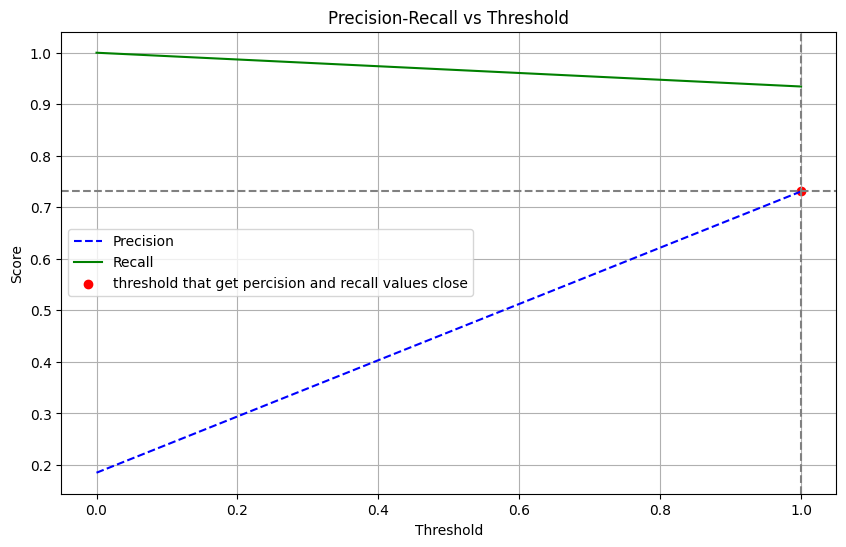

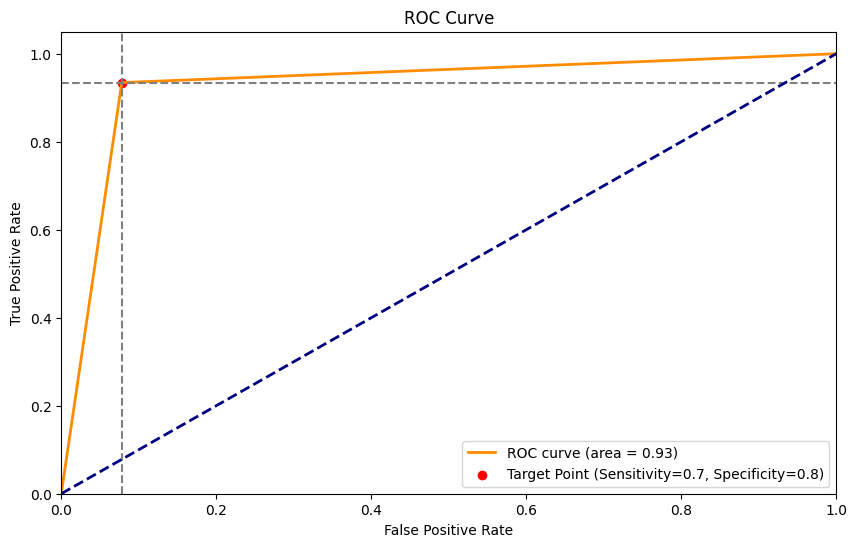

In [ ]:
y_train_pred = gru_model.predict(X_train) >=0.5
y_test_pred = gru_model.predict(X_test) >=0.5
print(precision_score(y_train_encoded, y_train_pred))
print(recall_score(y_train_encoded, y_train_pred))
print(precision_score(y_test_encoded, y_test_pred))
print(recall_score(y_test_encoded, y_test_pred))

precision, recall, thresholds = precision_recall_curve(y_train_encoded, y_train_pred)

plt.figure(figsize=(10, 6))
plot_precision_recall_vs_threshold(precision, recall, thresholds)
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_encoded, y_train_pred)

plt.figure(figsize=(10, 6))
plot_roc_curve_with_target_point(fpr, tpr, thresholds, target_sensitivity=0.7, target_specificity=0.8)